In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0,"/root/MorganFP_prediction/reproduce_previous_works/Spectre")
            
import torch
torch.set_printoptions(precision=10)

from models.optional_input_ranked_transformer import OptionalInputRankedTransformer
from datasets.optional_2d_folder_dataset import OptionalInputDataModule
import yaml
torch.set_float32_matmul_precision('medium')
from pathlib import Path

from rdkit import Chem
from rdkit.Chem import Draw
# load model 
from datasets.dataset_utils import fp_loader_configer, plot_NMR

fp_loader_configer.select_version("MFP_Specific_Radius")
specific_radius_mfp_loader = fp_loader_configer.fp_loader


            


In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, message="You are using `torch.load` with `weights_only=False`")
warnings.filterwarnings("ignore", category=UserWarning, message="The PyTorch API of nested tensors is in prototype stage and will change in the near future.")


In [3]:
import numpy as np 
import random
seed=2
torch.cuda.manual_seed_all(seed) 
np.random.seed(seed)
random.seed(seed)


In [4]:
p = Path("/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_c_trial_1/checkpoints/epoch=16-step=27472.ckpt")
p.parents[1]

PosixPath('/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_c_trial_1')

In [5]:
# load model 

def choos_model(model_type):
    match model_type:
        case "C-NMR":
            checkpoint_path = Path("/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_c_trial_1/checkpoints/epoch=16-step=27472.ckpt")
        case "H-NMR":
            checkpoint_path = Path("/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_h_trial_1/checkpoints/epoch=29-step=43770.ckpt")
        case "HSQC":
            checkpoint_path = Path("/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_hsqc_trial_1/checkpoints/epoch=22-step=39422.ckpt")
        case "All-NMR":
            checkpoint_path = Path("/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/flexible_models_best_FP_optional_MW/r0_r2_FP_trial_1/checkpoints/epoch=42-all_inputs.ckpt")
            
        case _:
            raise ValueError(f"model_type: {model_type} not recognized")
    
    
    model_path = checkpoint_path.parents[1]
    hyperpaerameters_path = model_path / "hparams.yaml"

    # checkpoint_path = model_path / "checkpoints/epoch=14-step=43515.ckpt"


    with open(hyperpaerameters_path, 'r') as file:
        hparams = yaml.safe_load(file)
        
    FP_building_type = hparams['FP_building_type'].split("_")[-1]
    only_2d = not hparams['use_oneD_NMR_no_solvent']
    # only_2d = True
    print(FP_building_type)
    max_radius = int(hparams['FP_choice'].split("_")[-1][1:])
    print("max_radius: ", max_radius)
    
    if  max_radius!=specific_radius_mfp_loader.max_radius or only_2d!=specific_radius_mfp_loader.only_2d:
        specific_radius_mfp_loader.setup(only_2d=only_2d,FP_building_type=FP_building_type)
        specific_radius_mfp_loader.set_max_radius(int(hparams['FP_choice'].split("_")[-1][1:]), only_2d=only_2d)


    del hparams['checkpoint_path'] # prevent double defition of checkpoint_path
    hparams['use_peak_values'] = False
    model = OptionalInputRankedTransformer.load_from_checkpoint(checkpoint_path, **hparams)
    
    datamodule = OptionalInputDataModule(dir="/workspace/SMILES_dataset", FP_choice=hparams["FP_choice"], input_src=["HSQC", "oneD_NMR"], batch_size=1, parser_args=hparams)
    datamodule.setup("predict")
    loader_all_inputs, loader_HSQC_H_NMR, loader_HSQC_C_NMR, loader_only_hsqc, loader_only_1d, loader_only_H_NMR, loader_only_C_NMR = \
        datamodule.predict_dataloader()
        
    match model_type:
        case "C-NMR":
            test_loader = loader_only_C_NMR
        case "H-NMR":
            test_loader = loader_only_H_NMR
        case "HSQC":
            test_loader = loader_only_hsqc
        case "All-NMR":
            test_loader = loader_all_inputs            
        case _:
            raise ValueError(f"model_type: {model_type} not recognized")
        
    
        
    return hparams, model, test_loader




In [6]:
hparams, model , test_loader = choos_model("All-NMR")


Normal
max_radius:  2
loading time: 45.14953827857971
counting time: 9.584053039550781
finish entropy list


Initialized SignCoordinateEncoder[384] with dims [180, 180, 24] and 2 positional encoders. 24 bits are reserved for encoding the final bit


HsqcRankedTransformer saving args
None
out_dim is  6144


In [7]:
hparams['FP_building_type'].split("_")[-1]

'Normal'

In [8]:
# model = OptionalInputRankedTransformer.load_from_checkpoint(Path("/root/MorganFP_prediction/reproduce_previous_works/fix_combining_dataset_load_mfp_bug/train_on_all_data_possible/only_c_trial_1/checkpoints/epoch=16-step=27472.ckpt"), **hparams)

In [9]:


# datamodule.setup("test")
# loader_only_hsqc = datamodule.test_dataloader()
    
# model=model.to("cuda")

In [10]:
model.device

device(type='cuda', index=0)

In [11]:
# set up ranking set

import pickle 
choice = "test"
index_to_smiles = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/SMILES/index.pkl', 'rb'))


all_FP_indices_in_folder = pickle.load(open(f'/root/MorganFP_prediction/reproduce_previous_works/Spectre/datasets/{choice}_indices_of_full_info_NMRs.pkl', 'rb'))
all_added_smiles = set()
all_FP_indices_to_be_added = []
for i in all_FP_indices_in_folder:
    smile = index_to_smiles [int(i.split(".")[0])]
    if smile not in all_added_smiles:
        all_added_smiles.add(smile)
        all_FP_indices_to_be_added.append(i)
        
sorted_file_indices  = [int(file.split(".")[0]) for file in sorted(all_FP_indices_to_be_added)]
index_to_chemical_names = pickle.load(open(f'/workspace/SMILES_dataset/{choice}/Chemical/index.pkl', 'rb'))



In [12]:
for k,v in index_to_smiles.items():
    if v == "COC1OC(CO)C(O)C(O)C1O":
        print(k)
        break

9995


In [13]:
path_pickles = "/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebook_and_scripts/dataset_building/FP_on_bits_pickles/"
test_2d = pickle.load(open(path_pickles + f'Normal_FP_on_bits_r0_r15_len_6144_2d_test.pkl', 'rb'))

In [14]:
(test_2d[9995])

array([ 2704,  3067,  3105,  4176,  4791,  4903,  5748,  6193,  6235,
        6416,  7485,  7509,  8065,  8527,  8848,  9129,  9211,  9249,
        9282, 10320, 10447, 10449, 10935, 11047, 11388, 11892, 11997,
       12337, 12379, 12560, 12912, 13105, 13629, 13653, 14209, 14347,
       14671, 14992, 15119, 15273, 15355, 15393, 15426, 15432, 15891,
       16128, 16338, 16464, 16591, 16593, 16709, 17079, 17191, 17459,
       17476, 17532, 18036, 18141, 18481, 18523, 18609, 18704, 18954,
       18982, 19056, 19249, 19773, 19797, 19975, 20353, 20491, 20815,
       20907, 21136, 21263, 21417, 21499, 21537, 21570, 21576, 22035,
       22081, 22272, 22286, 22327, 22482, 22608, 22735, 22737, 22853,
       23223, 23335, 23603, 23620, 23676, 24180, 24285, 24625, 24667,
       24753, 24762, 24848, 25098, 25126, 25200, 25249, 25393, 25601,
       25900, 25917, 25941, 26119, 26497, 26635, 26959, 27051, 27280,
       27407, 27561, 27643, 27681, 27714, 27720, 28179, 28225, 28409,
       28416, 28430,

In [15]:
FP_on = test_2d[9995]
FP_on.dtype

dtype('int64')

In [16]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import Chem
radius = 1
length = 6144
mol = Chem.MolFromSmiles("COC1OC(CO)C(O)C(O)C1O")
mol = Chem.AddHs(mol)
gen = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=length)
ao = rdFingerprintGenerator.AdditionalOutput()
ao.AllocateBitInfoMap()
fp = gen.GetFingerprint(mol, additionalOutput=ao)
bitInfo = ao.GetBitInfoMap()

print([k+6144*radius for k in bitInfo.keys()])

[6193, 6235, 6416, 7485, 7509, 8065, 8527, 8848, 9129, 9211, 9249, 9282, 10320, 10447, 10449, 10935, 11047, 11388, 11892, 11997]


In [17]:
kept = specific_radius_mfp_loader.indices_kept
max(kept), min(kept)

(np.int64(18431), np.int64(192))

In [18]:
huge_mfp = np.zeros(16*6144)
huge_mfp[FP_on] = 1
huge_mfp[kept].nonzero()

(array([   0,    1,   24,   27,   39,   40,   41,   42,   43,   44,   45,
          46,   47,   48,   49,   50,   51,   66,   67,   68,   69,   70,
          89,   90,  103,  105,  114,  118,  121,  122,  124,  126,  128,
         137,  138,  139,  140,  141,  150,  162,  213,  214,  378,  385,
         395,  535,  536,  537,  539,  540,  598,  599,  600, 3707]),)

In [19]:
# which_compound = 5
# filename = loader_all_inputs.dataset.files[which_compound]

# f_path = os.path.join(loader_all_inputs.dataset.dir, "oneD_NMR", filename)
# if os.path.exists(f_path):
#     c_tensor, h_tensor = torch.load(f_path)
    
# hsqc = torch.load(f_path.replace("oneD_NMR", "HSQC"))

# # print(f_path)
# chemical_names_lookup = pickle.load(open(f'/workspace/SMILES_dataset/test/Chemical/index.pkl', 'rb'))
# print(chemical_names_lookup[int(filename.split(".")[0])] + "\n" +index_to_smiles[int(filename.split(".")[0])])
# print(filename)

In [20]:
# (index_to_smiles[int(filename.split(".")[0])], index_to_chemical_names[int(filename.split(".")[0])])

In [21]:


# plot_NMR(hsqc, c_tensor, h_tensor)

In [22]:
# import torch.nn.functional as F
# import heapq

# def retrieve_top_k_by_dir(dir, prediction_query, smiles_and_names , k=30):
#     query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()
#     results = []
#     for  ranker_f in sorted(os.listdir(dir), key=lambda x:int(x.split("_")[1].split(".")[0])):
#     # for num_ranker_data, ranker_f in [(54,"FP_54.pt")]:
#         # print(ranker_f)
#         num_ranker_data = int(ranker_f.split("_")[1].split(".")[0])
#         data = torch.load(os.path.join(dir, ranker_f)).to("cuda")
#         query_products = (data @ query)
#         values, indices = torch.topk(query_products,k=k)
#         if len(results) == 0:
#             for value, idx in zip(values, indices):
#                 real_idx = idx + 2000*num_ranker_data
#                 heapq.heappush(results, (value, real_idx, data[idx].nonzero()))
#         else:
#             for value, idx in zip(values, indices):
#                 real_idx = idx + 2000*num_ranker_data
#                 heapq.heappushpop(results, (value, real_idx, data[idx].nonzero()))    
                
                        
#     results.sort(key=lambda x: x[0],reverse=True)
#     ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
#     # print(torch.tensor(idx))
#     # retrieved_FP = [all_fp[i] for i in idx]
#     # print(results[0])
  
#     return ret

# def retrieve_top_k_by_rankingset(data, prediction_query, smiles_and_names , k=30):
#     query = F.normalize(prediction_query, dim=1, p=2.0).squeeze()

#     results = []
#     query_products = (data @ query)
#     values, indices = torch.topk(query_products,k=k)
    
#     for value, idx in zip(values, indices):
#         results.append((value, idx, data[idx].nonzero()))
                
                        
#     results.sort(key=lambda x: x[0],reverse=True)
#     ret = [(value, smiles_and_names[i], fp) for value, i, fp in results]
#     # print(torch.tensor(idx))
#     # retrieved_FP = [all_fp[i] for i in idx]
#     # print(results[0])
  
#     return ret
        

In [23]:
smiles_and_names = pickle.load(open(f'/root/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/inference_metadata.pkl', 'rb'))

In [24]:
len(smiles_and_names), (smiles_and_names[0])

(526319,
 ('COCc1c(O)c2c(c(C)c1OC1OC(CO)C(O)C(O)C1O)OC(c1ccc(OC)cc1)CC2=O',
  '"(2~{S})-5-hydroxy-6-(methoxymethyl)-2-(4-methoxyphenyl)-8-methyl-7-[(2~{S},3~{R},4~{S},5~{S},6~{R})-3,4,5-trihydroxy-6-(hydroxymethyl)tetrahydropyran-2-yl]oxy-chroman-4-one"',
  506.5040000000003,
  'Coconut DB'))

In [25]:
max_radius = specific_radius_mfp_loader.max_radius
rankingset_path = f"/root/MorganFP_prediction/inference_data/coconut_loutus_hyun_training/max_radius_{max_radius}_stacked_together/FP.pt"

rankingset_data = torch.load(rankingset_path)#.to("cuda")



In [26]:
specific_radius_mfp_loader.max_radius

2

In [27]:
len(rankingset_data), len(smiles_and_names)

(526319, 526319)

In [28]:
# def unpack_inputs(inputs):
#     for i, vals in enumerate(inputs[0]):
#         # if vals is [-1, -1, -1]
#         if vals[0]==-1 and vals[1]==-1 and vals[2]==-1:
#             hsqc_start=i+1
#         elif vals[0]==-2 and vals[1]==-2 and vals[2]==-2:
#             hsqc_end=i
#         elif vals[0]==-3 and vals[1]==-3 and vals[2]==-3:
#             c_nmr_start=i+1
#         elif vals[0]==-4 and vals[1]==-4 and vals[2]==-4:
#             c_nmr_end=i
#         elif vals[0]==-5 and vals[1]==-5 and vals[2]==-5:
#             h_nmr_start=i+1
#         elif vals[0]==-6 and vals[1]==-6 and vals[2]==-6:
#             h_nmr_end=i
            
#     hsqc = inputs[0,hsqc_start:hsqc_end]
#     c_tensor = inputs[0,c_nmr_start:c_nmr_end,0]
#     h_tensor = inputs[0,h_nmr_start:h_nmr_end,0]
#     return hsqc, c_tensor, h_tensor

# # unpack_inputs(inputs)

# # !!!
# def compute_cos_sim(fp1, fp2):
#     return (fp1 @ fp2) / (torch.norm(fp1) * torch.norm(fp2)).item()

from inference.inference_utils import retrieve_top_k_by_rankingset, compute_cos_sim, unpack_inputs_no_delimiter


In [29]:
model.device

device(type='cuda', index=0)

############################################### compound number: 1##############################################################
Ground Truth NMR
Chemical name METHYL GALACTOSIDE
Ground truth smiles COC1OC(CO)C(O)C(O)C1O


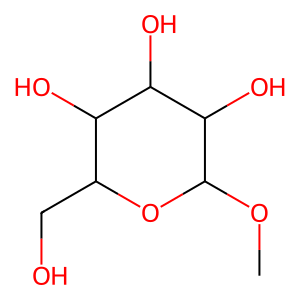

Prediction's cosine similarity to ground truth:  0.9720050096511841
________retival #1, cosine similarity to prediction: 0.4485644996166229_________________
SMILES: OCC1OC(Oc2c(O)cc(O)cc2O)C(O)C(O)C1O
Name "(2~{R},3~{S},4~{S},5~{R},6~{S})-2-(hydroxymethyl)-6-(2,4,6-trihydroxyphenoxy)tetrahydropyran-3,4,5-triol"


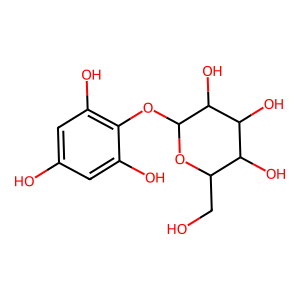

________retival #2, cosine similarity to prediction: 0.43806010484695435_________________
SMILES: COC1OC(CO)C(O)C(O)C1O
Name "(2~{S},3~{R},4~{R},5~{S},6~{S})-2-(hydroxymethyl)-6-methoxy-tetrahydropyran-3,4,5-triol"


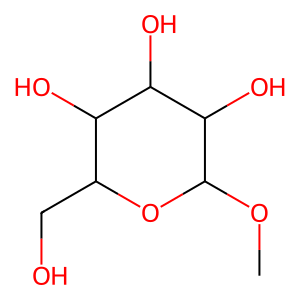

________retival #3, cosine similarity to prediction: 0.43533092737197876_________________
SMILES: COc1cc(O)cc(OC)c1OC1OC(CO)C(O)C(O)C1O
Name "(2~{S},3~{R},4~{S},5~{R},6~{R})-2-(4-hydroxy-2,6-dimethoxy-phenoxy)-6-(hydroxymethyl)tetrahydropyran-3,4,5-triol"


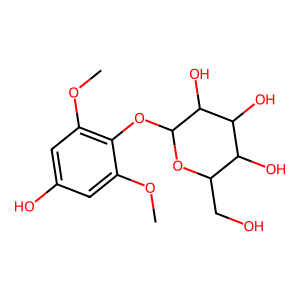

DONE






In [30]:
'''
show some examples from my dataset to check sanity
for a single model, show top-5
'''

model.to("cpu")
# for  which_compound in  random.sample(range(len(test_loader.dataset)), k=1):# range(0, 1):  
for which_compound in range(0, 1):
    
    print(f"############################################### compound number: {which_compound+1}##############################################################")
    
    for idx, batch in enumerate(test_loader):
        if idx < which_compound:
            continue
        inputs, extra_info = batch
        (smiles, names, NMR_type_indicator, path) = zip(*extra_info)
        # print(inputs.shape, inputs)
        # print(inputs, smiles_chemical_name)
        
        # batch[0] = batch[0].to("cuda")
        # hsqc, c_tensor, h_tensor = unpack_inputs_no_delimiter(inputs[0], NMR_type_indicator[0])
  
        inputs = inputs.to(model.device)
        NMR_type_indicator = NMR_type_indicator[0].to(model.device)
        pred = model(inputs, NMR_type_indicator)
        pred=torch.sigmoid(pred) # sigmoid
        pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
        # print(pred_FP.nonzero().squeeze().tolist())
        break
    # print(f"dataloader: {loader_all_inputs.dataset.latest_element_got}")
    
    # print(inputs)
    
    print("Ground Truth NMR")
    # plot_NMR(hsqc, c_tensor, h_tensor)
    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=3)
    # ground truth
    # smiles, names, path = zip(*smiles_chemical_name)
    mol = Chem.MolFromSmiles(smiles[0])
    print(f"Chemical name {names[0]}")
    print(f"Ground truth smiles {smiles[0]}")
    # print(f"Ground truth NMR path {path[0]}")
    img = Draw.MolToImage(mol)
    img.show()
    
    ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(smiles[0])
    print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
    # 
    i=0
    for value, (smile, name, _, _), retrieved_FP in topk:
        print(f"________retival #{i+1}, cosine similarity to prediction: {value.item()}_________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())

        print(f"SMILES: {smile}") 
        print(f"Name {name}")
        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        
print("DONE\n\n\n\n")
        



In [31]:
specific_radius_mfp_loader.build_mfp_for_new_SMILES("COC1OC(CO)C(O)C(O)C1O").nonzero()

tensor([[   0],
        [   1],
        [  24],
        [  27],
        [  39],
        [  40],
        [  41],
        [  42],
        [  43],
        [  44],
        [  45],
        [  46],
        [  47],
        [  48],
        [  49],
        [  50],
        [  51],
        [  66],
        [  67],
        [  68],
        [  69],
        [  70],
        [  89],
        [  90],
        [ 103],
        [ 105],
        [ 114],
        [ 118],
        [ 121],
        [ 122],
        [ 124],
        [ 126],
        [ 128],
        [ 137],
        [ 138],
        [ 139],
        [ 140],
        [ 141],
        [ 150],
        [ 162],
        [ 213],
        [ 214],
        [ 378],
        [ 385],
        [ 395],
        [ 535],
        [ 536],
        [ 537],
        [ 539],
        [ 540],
        [ 598],
        [ 599],
        [ 600],
        [3707]])

In [32]:
curr_SMILES = "COC1OC(CO)C(O)C(O)C1O"
curr_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(curr_SMILES)

retrieve_based_on_groudth(curr_FP.unsqueeze(dim=0), k=5)

NameError: name 'retrieve_based_on_groudth' is not defined

In [33]:
for index, (smiles, name, mw, source) in enumerate(smiles_and_names):
    if smiles == "COC1OC(CO)C(O)C(O)C1O":
        break

In [34]:
index, (smiles, name, mw, source) 

(2551,
 ('COC1OC(CO)C(O)C(O)C1O',
  '"(2~{S},3~{R},4~{R},5~{S},6~{S})-2-(hydroxymethyl)-6-methoxy-tetrahydropyran-3,4,5-triol"',
  194.18300000000002,
  'Coconut DB'))

In [35]:
rankingset_data[index].nonzero().squeeze().tolist()

[1,
 2,
 26,
 27,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 67,
 68,
 69,
 70,
 71,
 86,
 88,
 94,
 96,
 115,
 118,
 119,
 120,
 121,
 122,
 123,
 132,
 145,
 167,
 168,
 169,
 171,
 172,
 216,
 219,
 370,
 378,
 384,
 573,
 574,
 575,
 577,
 578,
 635,
 636,
 637,
 3625]

In [36]:
for index, (smiles, name, mw, source) in enumerate(smiles_and_names):
    if source not in [ "Coconut DB", "LOTUS DB", "hyunDB"]:
        break
index, (smiles, name, mw, source) 

(522226,
 ('COC1OC(CO)C(OC2OC(CO)C(OC)C(O)C2O)C(O)C1O',
  'Amylose',
  370.351,
  'training dataset train 1d'))

In [ ]:
'''
Show only incorrect inference examples
'''

# model.to("cuda")
i=0
for idx, batch in enumerate(loader_all_inputs):
    
    inputs, (smiles_chemical_name) = batch
    hsqc, c_tensor, h_tensor = unpack_inputs(inputs)
    inputs = inputs.to("cuda")
    pred = model(inputs)
    pred=torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())

    
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=1)
    # ground truth
    smiles, names, path = zip(*smiles_chemical_name)
    
    ground_truth_smiles = smiles[0]
    
    
    for value, (smile, name, _, _), retrieved_FP in topk:
        if smile != ground_truth_smiles:
            i+=1
            print(f"____________________incorrect retival #{i+1}________________________")
            print("Ground Truth NMR")
            plot_NMR(hsqc, c_tensor, h_tensor)
            ground_truth_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(ground_truth_smiles)
            print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()).item())
            
            
            
            mol = Chem.MolFromSmiles(smiles[0])
            print(f"Chemical name {names[0]}")
            print(f"Ground truth smiles {smiles[0]}")
            # print(f"Ground truth NMR path {path[0]}")
            img = Draw.MolToImage(mol)
            img.show()

           
            mol = Chem.MolFromSmiles(smile)
           
            print(f"SMILES: {smile}")
            print(f"Name {name}")
            img = Draw.MolToImage(mol)
            img.show()
    
    if i==80:
        break    
        
        
        


    



NameError: name 'loader_all_inputs' is not defined

In [18]:
idx

1385

In [19]:
def get_delimeter(delimeter_name):
    match delimeter_name:
        case "HSQC_start":
            return torch.tensor([-1,-1,-1]).float()
        case "HSQC_end":
            return torch.tensor([-2,-2,-2]).float()
        case "C_NMR_start":
            return torch.tensor([-3,-3,-3]).float()
        case "C_NMR_end":
            return torch.tensor([-4,-4,-4]).float()
        case "H_NMR_start":
            return torch.tensor([-5,-5,-5]).float()
        case "H_NMR_end":
            return torch.tensor([-6,-6,-6]).float()
        case "solvent_start":
            return torch.tensor([-7,-7,-7]).float()
        case "solvent_end":
            return torch.tensor([-8,-8,-8]).float()
        case "ms_start":
            return torch.tensor([-12,-12,-12]).float()
        case "ms_end":
            return torch.tensor([-13,-13,-13]).float()
        case _:
            raise Exception(f"unknown {delimeter_name}")

 

In [28]:


"""
Nice !
Now we can play with unkown molecule
"""
hsqc_mode = None
'''for a single model, show top-5'''
def show_topK(inputs, k=5, mode = hsqc_mode, ground_truth_FP=None):
    print("_________________________________________________________")

    
    inputs = inputs.unsqueeze(0).to("cuda")
    pred = model(inputs)
    pred = torch.sigmoid(pred) # sigmoid
    pred_FP = torch.where(pred.squeeze()>0.5, 1, 0)
    # print(pred_FP.nonzero().squeeze().tolist())
    if ground_truth_FP is not None:
        print("Prediction's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, pred_FP.to("cpu").float()))
        print("\n\n")
    topk = retrieve_top_k_by_rankingset(rankingset_data, pred, smiles_and_names, k=k)
       
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, retrival cosine similarity to prediction: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        # print("retrived FP", retrieved_FP.squeeze().tolist())
        if ground_truth_FP is not None:
            retrieved_FP_6144 = torch.zeros(6144)
            retrieved_FP_6144[retrieved_FP.cpu()] = 1
            print("Retrival's cosine similarity to ground truth: ", compute_cos_sim(ground_truth_FP, retrieved_FP_6144))
        print(f"SMILES: {smile}")
        print(f"Name {name}")
       
        #check is path file exists
        # print("retrieved path: ",oned_path)

        img = Draw.MolToImage(mol)
        img.show()
        i+=1
        



In [21]:
def build_input(compound_dir, mode = hsqc_mode, include_hsqc = True, include_c_nmr = True, include_h_nmr = True):
    print("\n\n")
    print(compound_dir.split("/")[-1])
    print("\n")
    def load_2d():
        return torch.tensor(np.loadtxt(os.path.join(compound_dir, "HSQC.txt"), delimiter=",")).float()
    def load_1d(nmr):
        vals = np.loadtxt(os.path.join(compound_dir, f"{nmr}.txt"), delimiter=",")
        vals = torch.tensor(np.unique(vals)).float()
        return F.pad(vals.view(-1, 1), (0, 2), "constant", 0)
    
    hsqc = load_2d()
    if hsqc is not None:
        hsqc[:,[0,1]] = hsqc[:,[1,0]]
        if mode == "no_sign":
            hsqc = torch.abs(hsqc)
        elif mode == "flip_sign":
            hsqc[:,2] = -hsqc[:,2]
    c_tensor = load_1d("C")
    h_tensor = load_1d("H")
    input_NMRs = []
    if include_hsqc:
        input_NMRs+= [get_delimeter("HSQC_start"),  hsqc,     get_delimeter("HSQC_end")]
    if include_c_nmr:
        input_NMRs+= [get_delimeter("C_NMR_start"), c_tensor, get_delimeter("C_NMR_end")]
    if include_h_nmr:
        input_NMRs+= [get_delimeter("H_NMR_start"), h_tensor, get_delimeter("H_NMR_end")]
    inputs = torch.vstack(input_NMRs)   
    with open(os.path.join(compound_dir, "mw.txt"), 'r') as file:
        # Read the content of the file
        content = file.read()
        # Convert the content to a float
        mw = float(content)
    mol_weight = torch.tensor([mw,0,0]).float()
    # print(inputs)
    # print(hsqc, c_tensor, h_tensor)
    # plot_NMR(hsqc, c_tensor[:,0], h_tensor[:,0])
    return torch.vstack([inputs, get_delimeter("ms_start"), mol_weight, get_delimeter("ms_end")])

In [22]:
Kavaratamide_A_SMILES = "CCCCCCC[C@H](O)CC(=O)N[C@@H](C(C)C)C(=O)N(C)[C@@H](C)C(=O)O[C@@H](C(C)C)C(=O)N1[C@@H](C(C)C)C(OC)=CC1=O"
Kavaratamide_A_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(Kavaratamide_A_SMILES)

newCompoundA_SMILES = "O=C1C(NC2=O)CCC(O)N1C(CC3=CC=CC=C3)C(N(C)C(CC4=CC(Br)=C(O)C=C4)C(NC(C(CC)C)C(OC(C)C(C(NC2CCCC[NH3+])=O)NC(C(NC(C(COS(=O)([O-])=O)OC)=O)CC5=CC=CC=C5)=O)=O)=O)=O"
newCompoundA_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES(newCompoundA_SMILES)

In [23]:
(newCompoundA_FP.dtype)

torch.float32

In [43]:
# look for the higher cos_sim possible in our dataset
def  retrieve_based_on_groudth(groud_truth_FP, k=5):
    topk = retrieve_top_k_by_rankingset(rankingset_data, groud_truth_FP, smiles_and_names, k=k) 
    
    i=0
    for ite, (value, (smile, name, _, _), retrieved_FP) in enumerate(topk):
        print(f"____________________________retival #{i+1}, cosine similarity: {value.item()}_____________________________")
        mol = Chem.MolFromSmiles(smile)
        print("retrived FP", retrieved_FP.squeeze().tolist())
        print(f"SMILES: {smile}")
        print(f"Name {name}")
        #check is path file exists
        # plot_NMR(hsqc, c_tensor, h_tensor)
        img = Draw.MolToImage(mol)
        img.show()
        i+=1


____________________________retival #1, cosine similarity: 0.6377196311950684_____________________________
retrived FP [6, 7, 8, 9, 10, 11, 12, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 77, 83, 109, 112, 113, 114, 117, 120, 124, 126, 128, 131, 134, 135, 136, 137, 138, 141, 144, 166, 167, 168, 169, 171, 172, 176, 177, 186, 193, 195, 201, 214, 216, 218, 219, 222, 224, 225, 238, 240, 241, 242, 258, 261, 266, 272, 284, 285, 349, 350, 352, 491, 502, 503, 504, 531, 573, 574, 575, 577, 578, 580, 597, 601, 612, 635, 636, 637, 662, 679, 680, 691, 782, 822, 833, 837, 900, 945, 1000, 1045, 1083, 1101, 1184, 1205, 1269, 1312, 1408, 1478, 1524, 1661, 1973, 2013, 2096, 2190, 2229, 2303, 2330, 2381, 2457, 2548, 2875, 2925, 3015, 3211, 3392, 3728, 3739, 3746, 3875, 4014, 4073, 4089, 4123, 4297, 4512, 4626, 4783, 4837, 4929, 5240, 5339, 5665, 5792, 5919]
SMILES: CCCCCCCC(CC=CCCC(=O)N(C)C(C)C(=O)NC(C)C(O)C(C)C(=O)N1C(=O)C=C(OC)C1C(C)C)OC
Name ['934248-75-6',

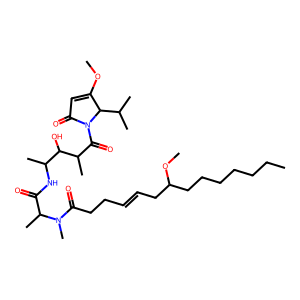

____________________________retival #2, cosine similarity: 0.6094380617141724_____________________________
retrived FP [0, 5, 6, 8, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 77, 83, 99, 100, 101, 102, 103, 112, 113, 114, 127, 129, 135, 136, 137, 138, 140, 141, 143, 167, 168, 169, 171, 172, 195, 214, 222, 224, 225, 239, 240, 241, 242, 256, 258, 261, 264, 334, 342, 349, 350, 352, 361, 375, 385, 502, 503, 504, 531, 544, 557, 573, 574, 575, 577, 578, 580, 597, 612, 635, 636, 637, 662, 672, 679, 680, 691, 712, 725, 745, 776, 778, 782, 788, 822, 827, 926, 1015, 1141, 1204, 1227, 1312, 1378, 1381, 1408, 1455, 1633, 1661, 1669, 1883, 1894, 1995, 2013, 2048, 2085, 2190, 2303, 2381, 2445, 2599, 2700, 2754, 2925, 3007, 3175, 3235, 3266, 3481, 3599, 3983, 4089, 4123, 4249, 4297, 4352, 4512, 4797, 4997, 5339, 5468, 5665, 5816, 6009]
SMILES: CCC(C)C(OC(=O)C(CC(C)C)N(C)C)C(=O)NC(C(=O)N1CCCC1C(=O)N1C(=O)C=C(OC)C1C(C)C)C(C)C
Name ['102147668']


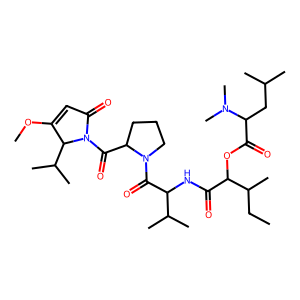

____________________________retival #3, cosine similarity: 0.6037452816963196_____________________________
retrived FP [3, 4, 6, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 54, 55, 62, 64, 66, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 109, 112, 113, 114, 117, 134, 135, 136, 137, 138, 141, 144, 166, 167, 168, 169, 171, 172, 176, 177, 188, 191, 195, 198, 201, 214, 222, 224, 225, 240, 241, 242, 349, 350, 352, 521, 573, 574, 575, 577, 578, 580, 597, 612, 633, 635, 636, 637, 689, 691, 715, 725, 745, 764, 768, 778, 818, 843, 883, 952, 953, 1016, 1041, 1132, 1204, 1227, 1408, 1455, 1540, 1577, 1639, 1816, 1883, 2013, 2303, 3058, 3213, 3682, 4897, 4997, 5339]
SMILES: CCCCC(C)C(=O)NC(C(=O)N1C(=O)C(C)=C(OC)C1Cc1ccccc1)C(C)C
Name ["palau'imide"]


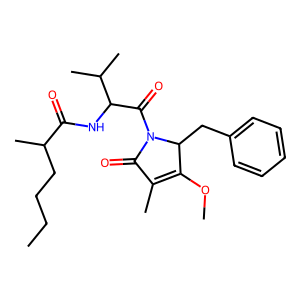

____________________________retival #4, cosine similarity: 0.5928528904914856_____________________________
retrived FP [3, 4, 6, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 112, 113, 114, 127, 135, 136, 137, 138, 141, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 222, 224, 225, 233, 234, 240, 241, 242, 258, 261, 349, 350, 352, 361, 375, 385, 502, 521, 573, 574, 575, 577, 578, 580, 597, 598, 607, 612, 635, 636, 637, 662, 679, 680, 691, 725, 745, 776, 778, 782, 822, 843, 952, 1015, 1016, 1132, 1141, 1204, 1227, 1312, 1376, 1408, 1440, 1455, 1478, 1669, 1721, 1883, 1996, 2013, 2048, 2096, 2303, 2534, 2663, 2754, 2837, 2925, 3257, 3266, 3392, 3636, 3913, 3924, 4089, 4297, 4512, 5000, 5330, 5339, 5665]
SMILES: CCC(C)C(C(=O)N1C(=O)C=C(OC)C1Cc1ccccc1)N(C)C(=O)C(C(C)C)N(C)C(=O)C(NC(=O)C(C(C)C)N(C)C)C(C)C
Name ['caldoramide']


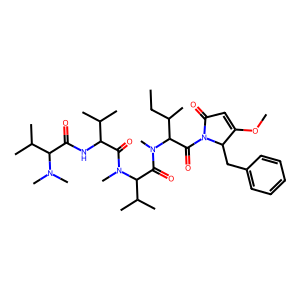

____________________________retival #5, cosine similarity: 0.5903822183609009_____________________________
retrived FP [6, 9, 14, 16, 17, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 62, 64, 66, 67, 68, 69, 70, 71, 112, 113, 114, 135, 136, 137, 138, 141, 167, 168, 169, 171, 172, 195, 204, 206, 207, 214, 222, 224, 225, 240, 241, 242, 258, 261, 349, 350, 352, 455, 465, 472, 551, 573, 574, 575, 577, 578, 580, 586, 597, 603, 635, 636, 637, 662, 712, 788, 839, 897, 912, 960, 1204, 1312, 1408, 1455, 1820, 1901, 1931, 2013, 2104, 2122, 2303, 2459, 2803, 2925, 3161, 3195, 3763, 3809, 4025, 4089, 4297, 4310, 4399, 4512, 4514, 4925, 5339, 5665, 6030]
SMILES: COC1=CC(=O)N(C(=O)C(CC(C)C(Cl)(Cl)Cl)NC(=O)CC(C)C(Cl)(Cl)Cl)C1C
Name ['(2S,5S,7S,15S)-Dysideapyrrolidone', 'dysideapyrrolidone', 'Dysideapyrrolidone']


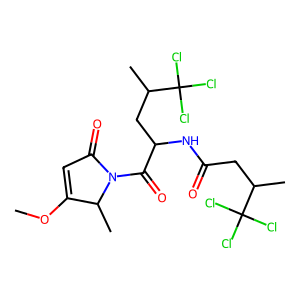

In [30]:
retrieve_based_on_groudth(Kavaratamide_A_FP.unsqueeze(dim=0).to("cuda"), k=5)

In [31]:
deepSAT_sintokamide_B_FP = specific_radius_mfp_loader.build_mfp_for_new_SMILES("CCC(=O)N[C@H](C[C@H](C)C(Cl)(Cl)Cl)C(=O)N1[C@H](C(=CC1=O)OC)C[C@H](C)C(Cl)(Cl)Cl")
compute_cos_sim(deepSAT_sintokamide_B_FP, Kavaratamide_A_FP)

tensor(0.6227116585)




Kavaratamide A


_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6870455742)



____________________________retival #1, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-docosancarbonsaeure-(2)-methylester; Mycolipanolsaeuremethylester']


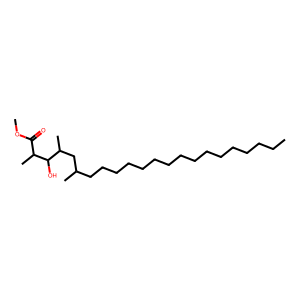

____________________________retival #2, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-heneicosancarbonsaeure-(2)-methylester; Mycolipanolsaeuremethylester']


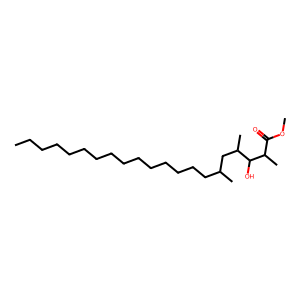

____________________________retival #3, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-tetracosancarbonsaeure-(2)-methylester']


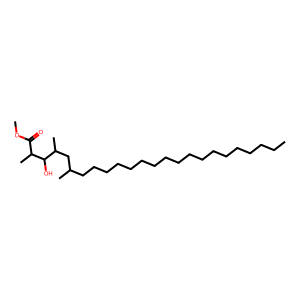

____________________________retival #4, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-pentacosancarbonsaeure-(2)-methylester']


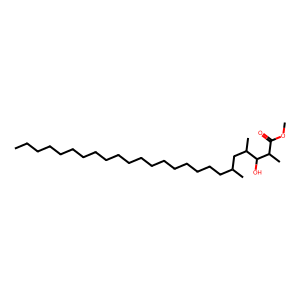

____________________________retival #5, retrival cosine similarity to prediction: 0.5829610824584961_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.4898041189)
SMILES: CCCCCCCCCCCCCCCCCCCCC(C)CC(C)C(O)C(C)C(=O)OC
Name ['(4S,6S)-2,3-erythro-3-Hydroxy-4,6-dimethyl-hexacosancarbonsaeure-(2)-methylester']


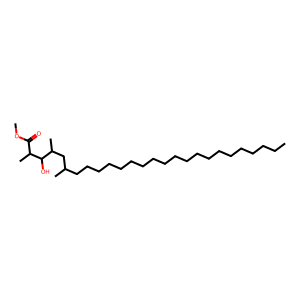

In [32]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/Kavaratamide A"
mode = None#"flip_sign"
inputs = build_input(compound_dir, mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5, mode=mode, ground_truth_FP = Kavaratamide_A_FP)
# show_topK(inputs, k=1)

____________________________retival #1, cosine similarity: 0.7450761795043945_____________________________
retrived FP [0, 1, 2, 3, 4, 5, 6, 9, 14, 16, 17, 22, 23, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 57, 59, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 99, 100, 101, 102, 103, 112, 113, 114, 134, 135, 136, 137, 138, 141, 144, 147, 150, 151, 153, 154, 155, 156, 157, 158, 166, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 216, 219, 222, 224, 225, 235, 240, 241, 242, 251, 259, 268, 297, 309, 319, 322, 323, 336, 337, 340, 341, 349, 350, 352, 354, 361, 362, 363, 367, 375, 377, 385, 386, 485, 496, 521, 573, 574, 575, 577, 578, 580, 592, 597, 598, 603, 612, 614, 617, 635, 636, 637, 674, 691, 755, 779, 798, 807, 816, 829, 833, 843, 848, 875, 887, 897, 918, 919, 920, 942, 948, 952, 973, 996, 1000, 1016, 1038, 1045, 1050, 1098, 1132, 1143, 1157, 1172, 1305, 1311, 1341, 1362, 1403, 1429, 1439, 1513, 1522, 1527, 1559, 1619, 1650, 1661, 1693, 1703, 1736, 1904, 1922, 1957, 

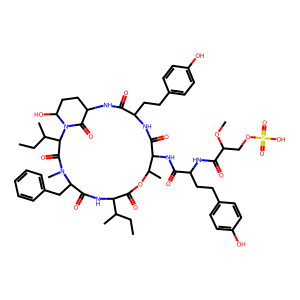

____________________________retival #2, cosine similarity: 0.7397352457046509_____________________________
retrived FP [0, 1, 2, 3, 4, 5, 6, 9, 14, 16, 17, 22, 23, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 57, 59, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 99, 100, 101, 102, 103, 112, 113, 114, 135, 136, 137, 138, 141, 147, 150, 151, 153, 154, 155, 156, 157, 158, 166, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 216, 219, 222, 224, 225, 235, 240, 241, 242, 251, 259, 268, 297, 309, 319, 322, 323, 336, 337, 340, 341, 349, 350, 352, 354, 361, 362, 363, 367, 375, 377, 385, 386, 485, 496, 521, 573, 574, 575, 577, 578, 592, 598, 612, 614, 617, 635, 636, 637, 674, 691, 755, 779, 798, 807, 816, 829, 833, 843, 848, 875, 887, 918, 919, 920, 942, 948, 952, 973, 996, 1000, 1016, 1038, 1045, 1050, 1098, 1132, 1143, 1157, 1172, 1305, 1311, 1341, 1362, 1403, 1429, 1439, 1513, 1527, 1559, 1619, 1650, 1661, 1664, 1693, 1703, 1736, 1904, 1957, 1962, 2074, 2105, 2147, 2190, 2197, 

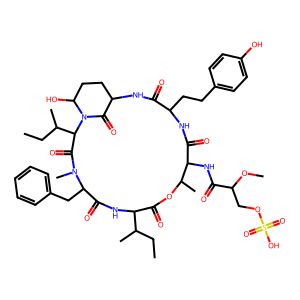

____________________________retival #3, cosine similarity: 0.7392309308052063_____________________________
retrived FP [0, 1, 2, 3, 4, 5, 6, 9, 14, 16, 17, 22, 23, 26, 27, 28, 29, 30, 33, 35, 36, 37, 38, 42, 44, 45, 46, 47, 48, 57, 59, 67, 68, 69, 70, 71, 73, 75, 77, 83, 97, 99, 100, 101, 102, 103, 109, 112, 113, 114, 117, 134, 135, 136, 137, 138, 141, 144, 147, 150, 151, 153, 154, 155, 156, 157, 158, 166, 167, 168, 169, 171, 172, 188, 191, 195, 198, 214, 216, 219, 222, 224, 225, 235, 240, 241, 242, 243, 251, 259, 268, 297, 302, 309, 316, 317, 318, 319, 322, 323, 336, 337, 340, 341, 349, 350, 352, 354, 361, 362, 363, 367, 375, 377, 385, 386, 485, 496, 521, 573, 574, 575, 577, 578, 580, 592, 597, 598, 603, 612, 614, 617, 635, 636, 637, 674, 691, 755, 779, 798, 807, 816, 829, 833, 843, 848, 875, 887, 893, 897, 908, 918, 919, 920, 942, 948, 952, 973, 996, 1000, 1016, 1038, 1045, 1050, 1098, 1132, 1143, 1157, 1172, 1228, 1305, 1311, 1341, 1362, 1429, 1439, 1513, 1520, 1522, 1527, 1559, 161

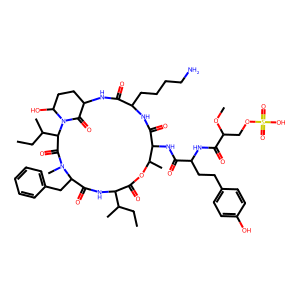

In [33]:
retrieve_based_on_groudth(newCompoundA_FP.unsqueeze(dim=0).to("cuda"), k=3)




new_compound_A




_________________________________________________________
Prediction's cosine similarity to ground truth:  tensor(0.6760917306)



____________________________retival #1, retrival cosine similarity to prediction: 0.712273120880127_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6645684838)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name ['(R)-N-((2S,5S,8S,11R,12S,15S,18S,21R)-5-Benzyl-2,8-Di-Sec-Butyl-15-(3-Guanidinopropyl)-21-Methoxy-4,11-Dimethyl-3,6,9,13,16,22-Hexaoxo-10-Oxa-1,4,7,14,17-Pentaazabicyclo[16.3.1]Docosan-12-Yl)-2,3-Dihydroxypropanamide', '45379634']


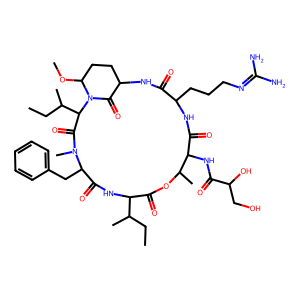

____________________________retival #2, retrival cosine similarity to prediction: 0.6942073702812195_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6634541154)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2O)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(O)CO)C(C)OC1=O
Name ['45379633', '(R)-N-((2S,5S,8S,11R,12S,15S,18S,21R)-5-Benzyl-2,8-Di-Sec-Butyl-15-(3-Guanidinopropyl)-21-Hydroxy-4,11-Dimethyl-3,6,9,13,16,22-Hexaoxo-10-Oxa-1,4,7,14,17-Pentaazabicyclo[16.3.1]Docosan-12-Yl)-2,3-Dihydroxypropanamide']


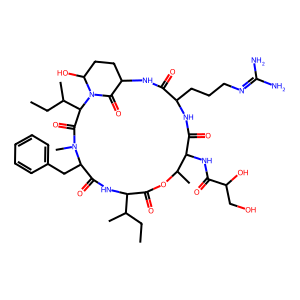

____________________________retival #3, retrival cosine similarity to prediction: 0.6925491094589233_____________________________
Retrival's cosine similarity to ground truth:  tensor(0.6731618643)
SMILES: CCC(C)C1NC(=O)C(Cc2ccccc2)N(C)C(=O)C(C(C)CC)N2C(=O)C(CCC2OC)NC(=O)C(CCCN=C(N)N)NC(=O)C(NC(=O)C(CO)OS(=O)(=O)O)C(C)OC1=O
Name ['(R)-1-((2S,5S,8S,11R,12S,15S,18S,21R)-5-Benzyl-2,8-Di-Sec-Butyl-15-(3-Guanidinopropyl)-21-Methoxy-4,11-Dimethyl-3,6,9,13,16,22-Hexaoxo-10-Oxa-1,4,7,14,17-Pentaazabicyclo[16.3.1]Docosan-12-Ylamino)-3-Hydroxy-1-Oxopropan-2-Yl Hydrogen Sulfate', '45379736']


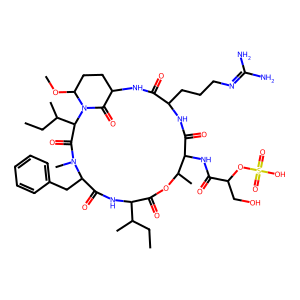

In [34]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_A"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=3, ground_truth_FP=newCompoundA_FP)




new_compound_B1




_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7176302671432495_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name ['kahalalide U']


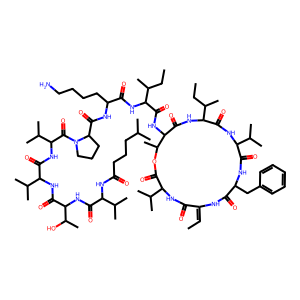

____________________________retival #2, retrival cosine similarity to prediction: 0.7170631289482117_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)CC)C(C)OC(=O)C(C(C)C)NC1=O
Name ['9898671', 'kahalalide F', '(2R)-N-[(2S)-5-Amino-1-[[(2R,3S)-1-[[(3S,6Z,9S,12R,15R,18R,19R)-9-Benzyl-15-[(2S)-Butan-2-Yl]-6-Ethylidene-19-Methyl-2,5,8,11,14,17-Hexaoxo-3,12-Di(Propan-2-Yl)-1-Oxa-4,7,10,13,16-Pentazacyclononadec-18-Yl]Amino]-3-Methyl-1-Oxopentan-2-Yl]Amino]-1-Oxopentan-2-Yl]-1-[(2R)-2-[[(2S)-2-[[(2S,3R)-3-Hydroxy-2-[[(2R)-3-Methyl-2-(5-Methylhexanoylamino)Butanoyl]Amino]Butanoyl]Amino]-3-Methylbutanoyl]Amino]-3-Methylbutanoyl]Pyrrolidine-2-Carboxamide', 'Kahalalide F']


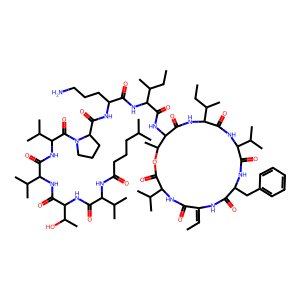

____________________________retival #3, retrival cosine similarity to prediction: 0.7151679992675781_____________________________
SMILES: CC=C1NC(=O)C(Cc2ccccc2)NC(=O)C(C(C)C)NC(=O)C(C(C)CC)NC(=O)C(NC(=O)C(NC(=O)C(CCCN)NC(=O)C2CCCN2C(=O)C(NC(=O)C(NC(=O)C(NC(=O)C(NC(=O)CCCC(C)C)C(C)C)C(C)O)C(C)C)C(C)C)C(C)C)C(C)OC(=O)C(C(C)C)NC1=O
Name ['kahalalide T']


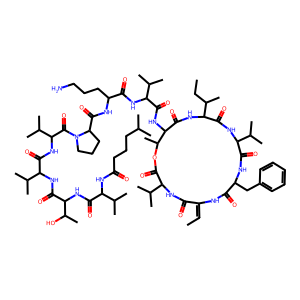

In [35]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B1"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=3)




new_compound_B2




_________________________________________________________
____________________________retival #1, retrival cosine similarity to prediction: 0.7562535405158997_____________________________
SMILES: CCCC(=O)NC(C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C)C(C)C
Name ['xentrivalpeptide D']


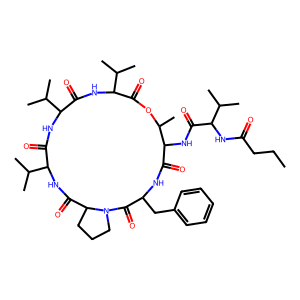

____________________________retival #2, retrival cosine similarity to prediction: 0.7486770749092102_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name ['1401343-49-4']


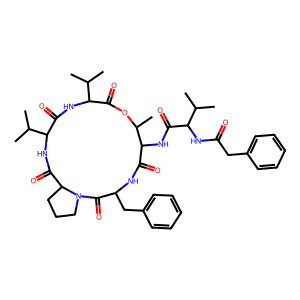

____________________________retival #3, retrival cosine similarity to prediction: 0.7486770749092102_____________________________
SMILES: CC(C)C(NC(=O)Cc1ccccc1)C(=O)NC1C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)NC(C(C)C)C(=O)OC1C
Name ['XENTRIVALPEPTIDE A']


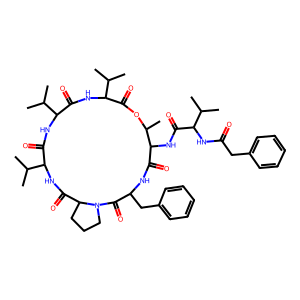

____________________________retival #4, retrival cosine similarity to prediction: 0.7380786538124084_____________________________
SMILES: CC(C)CC1NC(=O)C(NC(=O)C(NC(=O)Cc2ccccc2)C(C)C)C(C)OC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C(C(C)C)NC(=O)C2CCCN2C1=O
Name ['Xentrivalpeptide L']


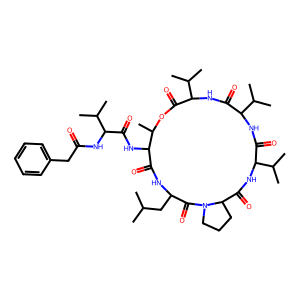

____________________________retival #5, retrival cosine similarity to prediction: 0.7194482088088989_____________________________
SMILES: CCC(C)C(NC(=O)C(Cc1ccccc1)NC(=O)C(CC(C)C)NC(=O)C1CCCN1C(=O)C1=CNC(C(C)C)C(=O)N2CCCC2C(=O)NC(C(C)C)C(=O)NC(Cc2ccccc2)C(=O)N2CCCC2C(=O)N1)C(=O)O
Name ["1-{[(6S,8E,11aS,17S,20S,22aS)-17-Benzyl-6,20-diisopropyl-5,11,16,19,22-pentaoxo-2,3,6,7,10,11,11a,12,13,14,16,17,18,19,20,21,22,22a-octadecahydro-1H,5H-dipyrrolo[1,2-a:1',2'-j][1,4,7,10,13,16]hexaazac\r\nyclooctadecin-9-yl]carbonyl}-L-prolyl-L-leucyl-L-phenylalanyl-L-isoleucine"]


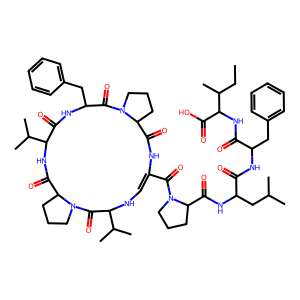

In [36]:
compound_dir = "/root/MorganFP_prediction/inference_data/testing_compounds/new_compound_B2"
inputs = build_input(compound_dir,
                     mode=mode,
                     include_h_nmr=False, include_c_nmr=False
                     )
show_topK(inputs, k=5)